In [315]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.helpers import read_raw_dataset, read_saved_dataframe, save_dataframe, debug_dataframe

## Q3.1 Do people care more about lyrics?

### Description :

In this question we will try to find wether people tend to listen to songs that contains certain terms or themes and if popular songs themes differ from the ones discussed in unpopular tracks.
To this end we will use the MusiXmatch dataset that is using the following format : 

Single .txt file: mxm_dataset_train.txt
      - list of top words, comma-separated
      - normal line, contains track_id, mxm track id,
        then word count for each of the top words, comma-separated
        word count is in sparse format -> ...,<word idx>:<cnt>,...
        <word idx> starts at 1 (not zero!)
            
Remember all the results and dataset are using a stemmed version of the words!

In [316]:
# load dataset
df_msd_songs   = read_raw_dataset("msd_songs")
df_msd_summary = read_raw_dataset("msd_summary")
df_mxm_lyrics = read_raw_dataset("mxm_lyrics")
df_mxm_words = read_raw_dataset("mxm_words")

We first choose to take only a subset of the songs with the highest/lowest song_hotttnesss, which is our reference for the poplarity of a song. A hotttnesss of at least 0.8 is clearly popular and one of at most 0.2 is unpopular.

In [317]:
#worst = True to take the worst songs (less hotttness)
worst = False
if(worst):
    #Here we take the worst 10000 songs sorted by hotttnesss
    df_top_songs = df_msd_summary[['song_hotttnesss', 'track_id',"title","artist_name","duration"]].sort_values('song_hotttnesss',ascending=True).loc[df_msd_summary['song_hotttnesss'] <= .2].head(10000)
else:
    #Here we take the top 2000 songs sorted by hotttnesss
    df_top_songs = df_msd_summary[['song_hotttnesss', 'track_id',"title","artist_name","duration"]].sort_values('song_hotttnesss',ascending=False).loc[df_msd_summary['song_hotttnesss'] <= 1].head(2000)
df_top_songs = df_top_songs.set_index('track_id')
df_top_songs.head()

,song_hotttnesss,title,artist_name,duration
track_id,,,,
TRYTLWJ128F1482624,1.0,The Killing Moon,Echo And The Bunnymen,347.34975
TRRVILL128F9307C9F,1.0,Panic Switch (UK edit),Silversun Pickups,253.75302
TRNSQDY128F9366831,1.0,This Is War,30 Seconds To Mars,326.97424
TRBFNSL128F42776F9,1.0,Immigrant Song (Album Version),Led Zeppelin,145.05751
TRQJUSS128E07861A6,1.0,Little Sister,Queens Of The Stone Age,211.56526


Here is an example of what the musiXmatch dataset is looking like :

In [318]:
df_mxm_lyrics.sort_values('count',ascending=False).head()

,track_id,mxm_tid,word,count,is_test
2175736,TRDIEOU128F4261A22,775220,i,1110,0
2175737,TRDIEOU128F4261A22,775220,the,1036,0
2175786,TRDIEOU128F4261A22,775220,woman,718,0
2175762,TRDIEOU128F4261A22,775220,see,700,0
2175743,TRDIEOU128F4261A22,775220,it,638,0


From this dataset we decide to remove stopwords which we consider to be uninformative (such as I, the, a...) and then get the most repeated word in every single track.

In [319]:
#We remove all lines containing stopwords
stop_wrds = open("./datasets/AdditionalFiles/stop_words.txt","r")
lines = stop_wrds.read().split('\n')
df_mxm_lyrics = df_mxm_lyrics[~df_mxm_lyrics.word.isin(lines)]
df_lyrics = df_mxm_lyrics
df_lyrics = df_lyrics.groupby('track_id')['count','word'].max()
df_lyrics.head()

,count,word
track_id,,
TRAAAAV128F421A322,2,worth
TRAAABD128F429CF47,7,yeah
TRAAAED128E0783FAB,11,whi
TRAAAEF128F4273421,17,world
TRAAAEW128F42930C0,11,wo


In [320]:
#We merge the two dataframes
df_top_songs_word = pd.merge(df_top_songs, df_lyrics, left_index=True, right_index=True, how='inner')
#get rid wrong durations some song is .7 seconds with 7 words occurences which is I think not physically possible
df_top_songs_word = df_top_songs_word[df_top_songs_word['duration'] > 1]
df_top_songs_word.head()

,song_hotttnesss,title,artist_name,duration,count,word
track_id,,,,,,
TRRVILL128F9307C9F,1.0,Panic Switch (UK edit),Silversun Pickups,253.75302,9,worth
TRNSQDY128F9366831,1.0,This Is War,30 Seconds To Mars,326.97424,22,world
TRENTGL128E0780C8E,1.0,Clocks,Coldplay,307.51302,9,want
TRIRQPO128F4281996,1.0,We Are The Sleepyheads,Belle & Sebastian,213.73342,3,whenev
TRQFXKD128E0780CAE,1.0,The Scientist,Coldplay,311.27465,17,tell


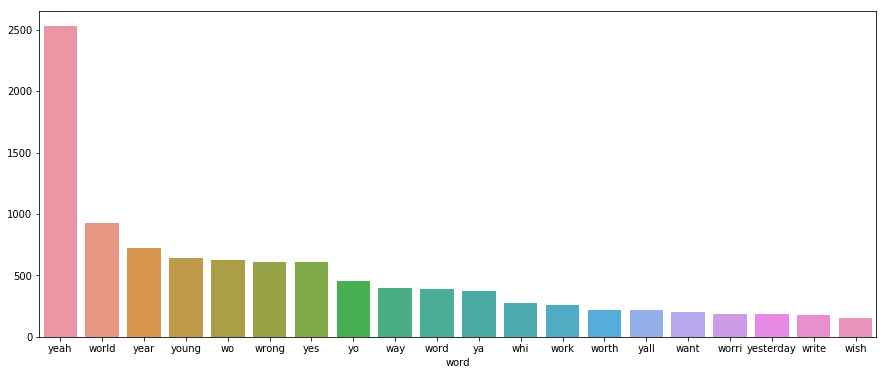

In [321]:
a = df_top_songs_word.groupby('word').sum().sort_values('count',ascending=False)[["count"]].head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']))
plt.show()
plt.close()

The top word is by far 'Yeah' and this result is very similar for the worst songs. Hence as a first conclusion we might say people do not really care about lyrics.

Next we add weight to top words in function of occurences per duration of song to get a more precise result

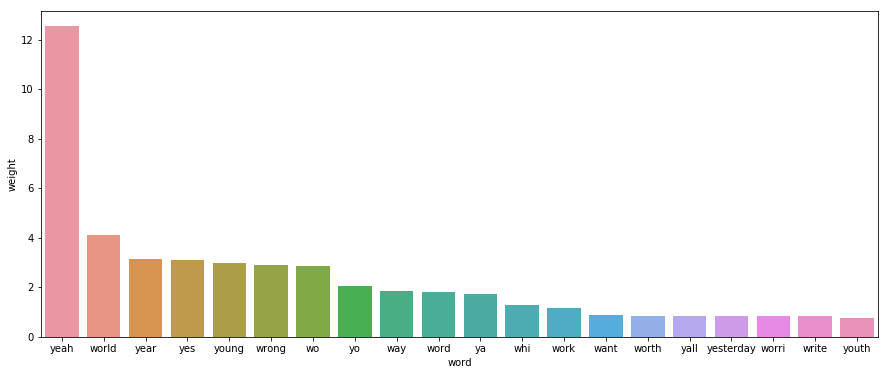

In [322]:
#weighted version
df_top_songs_word["weight"] = df_top_songs_word["count"]/df_top_songs_word["duration"]
a = df_top_songs_word.groupby('word').sum().sort_values('weight',ascending=False)[["count","weight"]].head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,a.weight)
plt.show()
plt.close()

Appart from 'yeah' we can see a lot of top words concerning themes such as youth, the world/people, and verbs that refer to desire(wish, want... (woman ?)) these are similar for the worst songs as well.

Now we consider the full lyrics dataset without taking care of hotttnesss and using counting all the words for every tracks, summing them up to see what is the most reccurent theme.

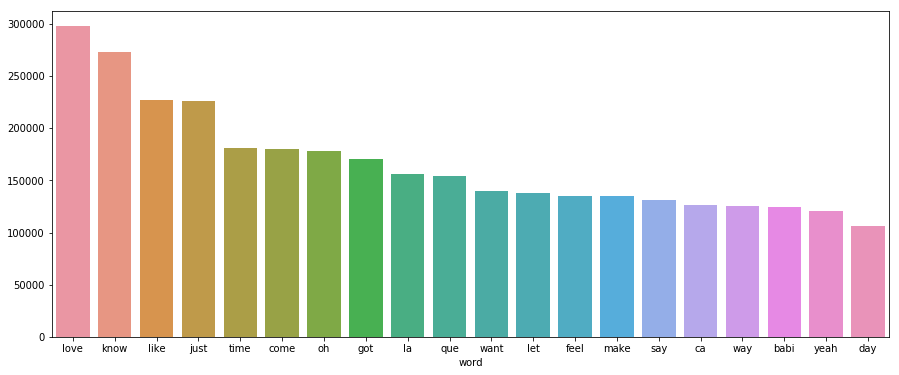

In [323]:
df_mxm_all_wrds = df_mxm_lyrics.groupby('word')['count','word'].sum()
a = df_mxm_all_wrds.sort_values('count',ascending=False).head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']))
plt.show()
plt.close()

Here we have a different and interesting result over all the songs we can see that the most recurent word is 'love' and there are many other high-ranked words that recall feelings (feel, like, want, baby, heart, girl...).

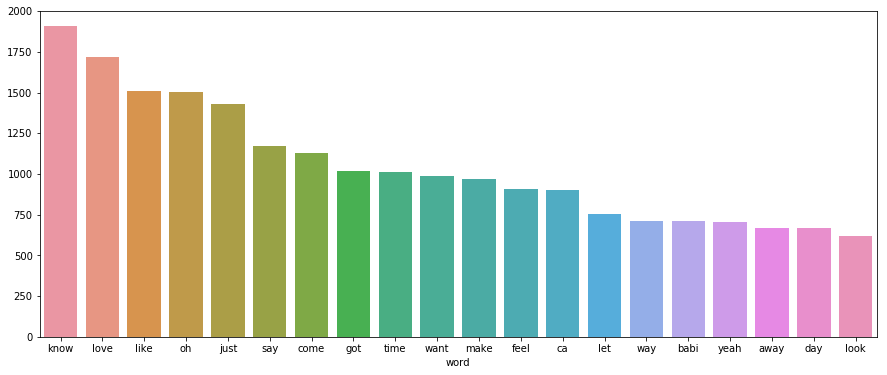

In [324]:
df_top_songs_all_wrds = pd.merge(df_top_songs, df_mxm_lyrics, left_index=True, right_on='track_id', how='inner')
df_top_songs_all_wrds = df_top_songs_all_wrds.groupby('word')['count','word'].sum()
a = df_top_songs_all_wrds.sort_values('count',ascending=False).head(20)
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
sns.barplot(a.index,list(a['count']))
plt.show()
plt.close()

We have quiet similar results for top/worst songs, in terms of lyrics we can say that top/worst songs are very similar in terms of themes addressed.

## Q3.2 Do the popular songs have the good quality of lyrics from literacy view points? Can we measure the quality and popularity of a song from its lyrics?

### Description: 

Here we will try to uncover some features that might be characteristic of popular songs, as a starting point we will focus on "slang" words such as insults or controversed subjects.


### "Slang" words part :

Here we use a text file that was used to provide an obscenity filter to find the slang words (please don't be offended by them).

In [325]:
import csv
with open('./datasets/AdditionalFiles/bad_words.csv', 'r') as f:
    reader = csv.reader(f)
    bad_words = list(reader)
bad_words = [row[1][:len(row[1])-1] for row in bad_words][4:]

In [326]:
#We retain the songs containing slang words.
df_mxm_bad = df_mxm_lyrics[df_mxm_lyrics.word.isin(bad_words)].sort_values("count",ascending = False)

In [327]:
df_bad_count = df_mxm_bad.groupby('track_id')['count','word'].sum()
df_top_bad_songs = pd.merge(df_top_songs, df_bad_count, left_index=True, right_index=True, how='inner')
print("We have a ratio of "+repr(len(df_top_bad_songs)/len(df_top_songs_word))+" top songs with bad words")
df_ratio = pd.merge(df_mxm_lyrics.groupby('track_id')['count','word'].sum(), df_top_bad_songs, left_index=True, right_index=True, how='inner')
df_ratio['ratio'] = df_ratio['count_y']/df_ratio['count_x']
df_ratio.sort_values('ratio',ascending=False)[['song_hotttnesss','title','ratio']].head()

We have a ratio of 0.3063533507397737 top songs with bad words


,song_hotttnesss,title,ratio
track_id,,,
TRQUHKZ128F930304E,0.884117,My Generation,0.214815
TROXWIE128F92D1249,0.895749,Dusk Till Dawn,0.210526
TRESXNP128EF350B90,0.899010,Fuck The Pain Away,0.198718
TRSKYDX12903CFA1D1,0.964620,Born to Party,0.194444
TRKMBDM128E0783E27,0.880696,Hollaback Girl,0.188119


We have a ratio of 0.3063533507397737 top songs with bad words. For the low hotttnesss songs we can actually see that we only have 0.22113502935420742 as a ratio. We can also see that some songs with a very high hotttness having 1/5 words being a slang word, so people might be more interested in borderline songs ?

### Lyrics density

Here we will try to see wether the sparsity of the lyrics in a songs influences its popularity (i.e. if a high density of words implies popularity).

In [328]:
df_density = df_mxm_lyrics.groupby("track_id").sum()
df_density = pd.merge(df_top_songs, df_density, left_index=True, right_index=True, how='inner')
df_density['density'] = df_density['count'] /df_density['duration']
df_density = df_density.sort_values('density',ascending = True)
df_density.head()

,song_hotttnesss,title,artist_name,duration,mxm_tid,count,is_test,density
track_id,,,,,,,,
TRNCXNX128F4282732,0.927425,Festival,Sigur Rós,565.13261,21852384,3,0,0.005308
TRLQUGG128F4261B0E,0.915077,Olsen Olsen,Sigur Ros,483.13424,4405912,6,0,0.012419
TRNKWUD128F92FEB41,0.900961,Music Is Math,Boards of Canada,321.46240,3361132,4,0,0.012443
TRWUKDU128F92E4963,0.879231,Om Nashi Me,Edward Sharpe & The Magnetic Zeros,376.05832,26090667,5,0,0.013296
TRFAOTA128E07989E0,0.940713,Heysátan,Sigur Rós,249.62567,11900784,6,0,0.024036


In [329]:
#We do this because theres a lot of wrong word count/duration
df_density= df_density.loc[df_density['density'] < 1.9]
print("On average we have "+repr(df_density['density'].mean())+" words per second for the top songs")

On average we have 0.45214054682294735 words per second for the top songs


We have 0.42832003048718376 for the worst and 0.45214054682294735 for the top the difference is quiet small and I do not think we can come to a conclusion due to the fact there might be many errors in the word counts.

As a conclusion we can say that most songs have reccurent themes (usually love and people) but these do not really influence the popularity of the song. We saw a slight trend for songs that contain slang/obscene words, they might be more popular than "polite" due to the fact they might shock the public ?
Also a song's popularity does not usually rely on the density or quality of their lyrics, as we saw in question 3.1 the most common word for the majority of the songs is 'yeah' and the lyrics sparsity isn't relevant either.

A next interesting step might by to try some natural language processing (sentiment analysis?) on the lyrics which might be difficult due to the fact we do not have complete sentences but only bag of words. 